In [1]:
import numpy as np
import gurobipy as gb
import pylab as pl

import seaborn as sns
sns.set_theme()

from src import *

# TSDAP/R
## Time Dependent Activity Scheduling Problem w/ Replenishments

### Problem definition



$\tau_i(t_i)$ is the time required to complete activity $i$ at time $t_i$.  
$e_i, l_i$ are the earliest start time and latest end time of activity $i$.  
$\rho_i(t_i)$ is the resource consumption of activity $i$ at time $t_i$.  
$Q$ is the total resource capacity  
$\theta_i(t_i) = t_i + \tau_i(t_i)$ is the completion time function.  

Minimize
$$\min_{t_j} \theta_n(t_n) = \min_{t_j} t_n + \tau_n(t_n)$$

subject to
$$\theta_i(t_i) \le t_{i+1}$$
$$\sum_{i=1}^{n} \rho_i(t_i) \le Q$$
$$t_i \in [e_i, l_i]$$

We assume the FIFO property: $\theta_i(t) \le \theta_i(t')$ if $t \le t'$

#### Solve TSDAP

$V_i = \{e_i, e_i + \epsilon, ..., l_i \}$ set of vertices for activity $i$  
$V = V_1 \cup ... \cup V_n$  
$q_{(i,t)} = \rho_i(t)$  
$l_{(i,t)}$ cumulative resource consumption prior to starting activity $i$ at time $t_i$.  
$W = \{(i, t) \in V \setminus \bar V \; | \; l_{(i, t)} + q_{(i,t)} \le Q\}$ set of still available vertices.


![](algorithm_1.png)

#### Implemented solution

The implemented algorithm differs from the one described in the paper by using a MinHeap to store the vertexes $W$ instead of a sorted list. This choice was made by analyzing the time complexity of the two algorithms, the sorted list has complexity $O(n^2m^2)$, while the MinHeap has complexity $O(nm(m+\log(mn)))$ and if we assume $n=am, \; a>0$ which is the case of the article, the complexity reduces to $O(nm^2)$. This enhanced version of the algorithm has also been discussed with the authors of the paper, who agree on the complexity.  

$$
TEN::solve(V, activities):
    
$$

### Data Model

We consider the problem of delivering n packages in a big city with time-dependent congestions. We assume that the delivery order of the packages has already been optimized by a routing algorithm and we seek a further optimization as to when to start each delivery in order to complete all of them as soon as possible.

We generate the data as follows:  
* The city is modelled as a traffic distribution over 2D space, which is peaked at the center of the city, and a traffic distribution over time, with two peaks during rush hours (8am and 5pm).
* The congestion level is a function of both these two functions and is computed as follows: 
```python
congestion = 1 / (1 - traffic_over_time(time))
sensitivity = traffic_over_space(point)
traffic = min(congestion*sensitivity + 1-sensitivity, 5)
```

The least amount of congestion is 1 while the maximum amount is capped at 5.  
The idea is that the traffic varies over time in the whole city, however, the intensity of the traffic is felt less and less the further you go away from the city center.  

####  Traffic over time
shape taken from https://www.tomtom.com/en_gb/traffic-index/new-york-traffic/

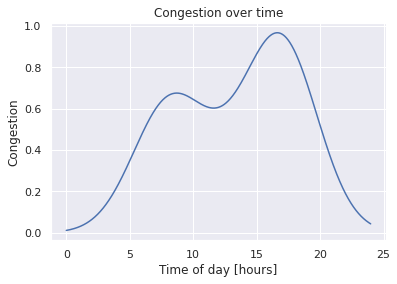

In [2]:
t = np.arange(0, 24*60)
pl.plot(t/60, traffic_over_time(t))
pl.title("Congestion over time")
pl.ylabel("Congestion")
pl.xlabel("Time of day [hours]")

pl.bbox_inches='tight'
pl.savefig("congestion_over_time.png", dpi=200)

#### Traffic over space  
A gaussian distribution centered around (0, 0)

/tmp/ipykernel_35402/245925704.py:5: UserWarning: The following kwargs were not used by contour: 'figsize'
  pl.contourf(xx, yy, traffic_over_space((xx, yy)), 100, figsize=(5,5), cmap="Reds", )


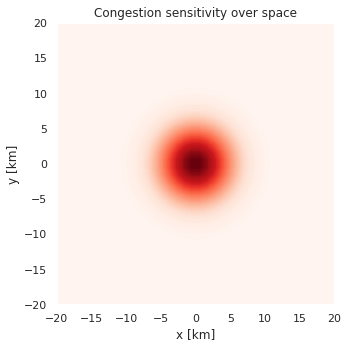

In [3]:
x = np.linspace(-20, 20, 40)
y = np.linspace(-20, 20, 40)
xx, yy = np.meshgrid(x, y)
pl.figure(figsize=(5, 5))
pl.contourf(xx, yy, traffic_over_space((xx, yy)), 100, figsize=(5,5), cmap="Reds", )
pl.title("Congestion sensitivity over space")
pl.ylabel("y [km]")
pl.xlabel("x [km]")
# pl.colorbar()

pl.tight_layout()
pl.savefig("sensitivity_over_space.png", dpi=200)

In [4]:
# A traffic model gives the traffic at a specified time and place in a city
model = TrafficModel(traffic_over_space, traffic_over_time)

#### Evolution of traffic over a day

In [5]:
x = np.linspace(-20, 20, 320)
y = np.linspace(-20, 20, 320)
xx, yy = np.meshgrid(x, y)

In [6]:
video = np.stack([model.traffic_level((xx, yy), i) for i in range(0, 24*60, 8)])
cmap = pl.get_cmap('Reds')
video = cmap((video-1) / 4 )

In [7]:
import torch
from torchvision.io import write_video

video = torch.from_numpy(video)

In [8]:
write_video("traffic_over_day.mp4", video[..., :3]*255, 24)

from IPython.display import Video
Video("traffic_over_day.mp4")

#### Travel time computation
Once a traffic model has been created we can use it to compute the travel time of all the routes that must be performed.  
We assume that a route goes from point A to point B always in a straight line, and we compute the time taken to travel the route by integration
$$x \rarr x+dx$$
$$t \rarr t + \mathrm{traffic}(x, t)dx$$
or
$$\partial t / \partial x = \mathrm{traffic}(x, t)$$
While this city model is not realistic, we need to evalutate the scalability of the implemented solutions so we don't need a perfect model of a city.

#### Resource consumption computation
We assume that the resource consumption is only dependent on the travel speed of the vehicle, so we used fuel-specific consumption functions that link the vehicle speed to the resources consumed when travelling at that speed, shown below.

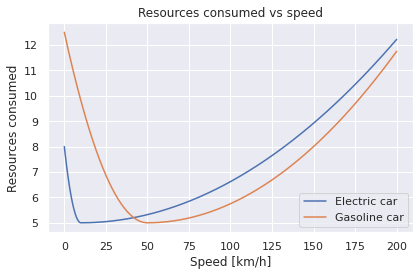

In [9]:
speeds = np.linspace(0, 200, 1000)
pl.plot(speeds, [ev_consumption(s) for s in speeds], label="Electric car")
pl.plot(speeds, [gasoline_consumption(s) for s in speeds], label="Gasoline car")
pl.title("Resources consumed vs speed")
pl.xlabel("Speed [km/h]")
pl.ylabel("Resources consumed")
pl.legend()

pl.tight_layout()
pl.savefig("resources_consumed.png", dpi=200)

The shapes were adapted from studies on how much fuel/power a car consumes at a given speed. We can see that a gasoline car has the lowest consumption at 50km/h, while for an electric car the faster it goes the higher the consumption.

The differential equation that governs the fuel consumed is the following
$$\partial \mathrm{resources} / \partial x = \mathrm{consumption}(\mathrm{speed}(x, t))$$
$$\mathrm{speed}(x, t) = 1 / \mathrm{traffic}(x, t)$$

Below we plot the travel time and resources cosnumed for electric and gasoline cars vs time of day

In [10]:
route = Route(traffic_model=model,
              energy_consumption=gasoline_consumption,
              start=np.array((0., 0.)),
              end=np.array((20., 20.)),
              base_speed=70)

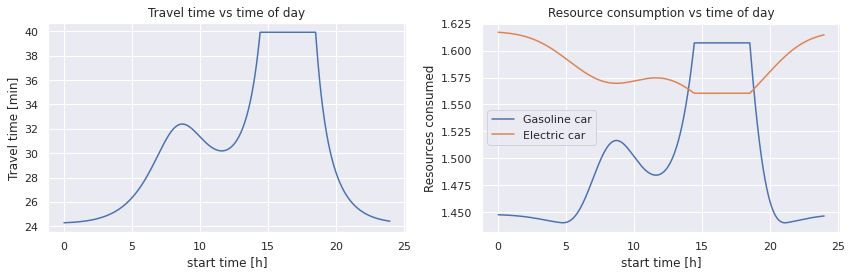

In [11]:
t = np.arange(0, 24*60)
fig, axes = pl.subplots(nrows=1, ncols=2, figsize=(12, 4))

route.energy_consumption=gasoline_consumption
axes[0].plot(t/60, [route.travel_time(i) for i in t])
axes[0].set_title("Travel time vs time of day")
axes[0].set_xlabel("start time [h]")
axes[0].set_ylabel("Travel time [min]")
axes[1].plot(t/60, [route.resources_consumed(i) for i in t], label="Gasoline car")

route.energy_consumption=ev_consumption
axes[1].plot(t/60, [route.resources_consumed(i) for i in t], label="Electric car")
axes[1].set_title("Resource consumption vs time of day")
axes[1].set_xlabel("start time [h]")
axes[1].set_ylabel("Resources consumed")
axes[1].legend()

pl.tight_layout()
pl.savefig("travel&resources_vs_time.png", dpi=200)

The travel time and resouce consumption clip because the maximum traffic is capped at 0.8, which corresponds to a travelling speed of 1/5 of the normal speed without traffic.

## Solution

### Data generation

In [12]:
# Problem parameters
n_activities = 20
Q = n_activities/2 # Total resources
eps = 1. # Time discretization factor
start_delivery = np.linspace(8, 12, n_activities)*60
end_delivery = start_delivery + 4*60

rng = np.random.default_rng(seed=42)
model = TrafficModel(traffic_over_space, traffic_over_time)
discretizer = TimeDiscretizer(eps)

In [13]:
# Generate activities
activities = []
start = rng.uniform(-8, 8, 2)
points = [start]
for e, l in zip(start_delivery, end_delivery):
    next = rng.uniform(-8, 8, 2)
    vehicle = ElectricVehicle(Q)
    route = Route(traffic_model=model,
                  energy_consumption=vehicle.consumption,
                  start=start,
                  end=next,
                  base_speed=50)
    start = next
    points.append(start)

    activities.append(Activity(e, l, route.travel_time, route.resources_consumed, vehicle.replenishment_time))
points = np.array(points).T

# Create V and q matrices
V, q = generate_V_and_q(activities, discretizer)

/tmp/ipykernel_35402/3268114280.py:5: UserWarning: The following kwargs were not used by contour: 'figsize', 'lable'
  pl.contourf(xx, yy, traffic_over_space((xx, yy)), 100, figsize=(5,5), cmap="Reds", lable="Traffic")


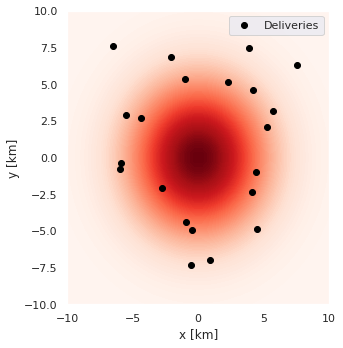

In [14]:
x = np.linspace(-10, 10, 40)
y = np.linspace(-10, 10, 40)
xx, yy = np.meshgrid(x, y)
pl.figure(figsize=(5, 5))
pl.contourf(xx, yy, traffic_over_space((xx, yy)), 100, figsize=(5,5), cmap="Reds", lable="Traffic")
pl.ylabel("y [km]")
pl.xlabel("x [km]")
pl.plot(points[0], points[1], 'o', color="black", label="Deliveries")
pl.legend()

pl.tight_layout()
pl.savefig("deliveries.png", dpi=200)

### Solutions

In [15]:
# Solve with TEN
sol = TEN_solve(V, activities, q, Q)
sol

Completion time: 808.12
Resources consumed: 8.14
Nodes visited: 230
Number of replenishments: 0

In [90]:
# Solve with DDD
sol = DDD_solve(activities, Q, discretizer, TEN_solve)
sol

Completion time: 808.12
Resources consumed: 8.14
Nodes visited: 64
Number of replenishments: 0

In [16]:
# Gurobi solution might be slightly different than the two above
# because we linearly interpolate the resources & duration functions
# However when eps -> 0 the two solutions will be the same
sol = gurobi_solve(activities, Q, discretizer)
sol.getJSONSolution().split("{ ")[2][:-12]

Set parameter Username
Academic license - for non-commercial use only - expires 2023-07-03


'"Status": 2, "Runtime": 1.0734736013412476e+02, "Work": 2.2981773006788060e+02, "ObjVal": 7.9894077732116818e+02, "ObjBound": 7.9892380384675607e+02, "ObjBoundC": 7.9892380384675607e+02, "MIPGap": 2.1244971960278716e-05, "IntVio": 0, "BoundVio": 0, "ConstrVio": 5.6843418860808015e-14, "IterCount": 317837, "BarIterCount": 0, "NodeCount": 2201, "SolCount": 10, "PoolObjBound": 7.9892380384675607e+02, "PoolObjVal": [ 7.9894077732116818e+02, 8.0144561572126224e+02, 8.0154663101433243e+02, 8.0161512348832389e+02, 801.714857556572, 8.0187010392939976e+02, 8.0188503667292025e+02, 8.0205256621483454e+02, 8.0270192808087324e+02, 8.2310560988274142e+02]}'

In [16]:
# Solve with Replenishments
sol = TEN_delta(V, activities, q, Q/2, discretizer)
sol

Completion time: 836.08
Resources consumed: 8.14
Nodes visited: 569
Number of replenishments: 1

In [18]:
# Solve with DDD with Replenishments
sol = DDD_solve(activities, Q/2, discretizer, TEN_delta)
sol

Completion time: 836.08
Resources consumed: 8.14
Nodes visited: 231
Number of replenishments: 1

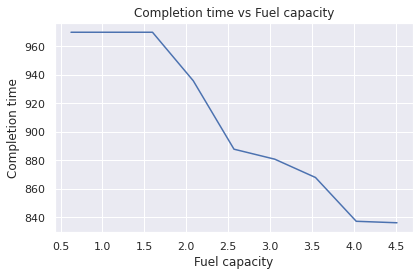

In [19]:
# Plot completion time vs fuel capacity with replenishments
Qs = np.linspace(Q/16, Q/2, 10)

times = []
for fuel_capacity in Qs:
    sol = TEN_delta(V, activities, q, fuel_capacity, discretizer)
    if sol is not None:
        times.append(sol.completion_time())

pl.plot(Qs[:len(times)], times)
pl.title("Completion time vs Fuel capacity")
pl.xlabel("Fuel capacity")
pl.ylabel("Completion time")

pl.tight_layout()
pl.savefig("time_vs_fuel.png", dpi=200)

## Scalability Study

To analyze the scalability of the proposed model, we avoid using the previous data model because the time required to compute the completion time and the resources used overshadows the actual scaling of the algorithms. This is expected, and our very simple model reflects a common problem in the real world, which is the time required to compute the shortest path between two locations in a city.

This leads us to consider two very simple functions to compute the activity resources and duration:

In [2]:
def resources(start_time: float) -> float:
    return np.sin(start_time) + 2


def duration(start_time: float) -> float:
    return np.cos(start_time) + 2

The functions are always > 0 and lower semi-continuous as required, the duration must satisfy an extra condition which is the FIFO property:
$$x + f(x) \leq y + f(y) \;\; \mathrm{if} \;\; x \leq y$$
Which can be rewritten by considering $y=x+dx$ and taking the limit as follows
$$f'(x) \geq -1$$
Our duration function satisfies the condition so we can safely use it.

## No Replenishments

In [2]:
def time_problem(n_activities, Q, eps, algorithm, repeat=1):
    discretizer = TimeDiscretizer(eps)
    activities, V, q = mock_problem(n_activities, discretizer)
    if algorithm == "TEN_solve":
        args = (V, activities, q, Q)
    if algorithm == "DDD_solve":
        args = (activities, Q, discretizer, TEN_solve)
    if algorithm == "gurobi_solve":
        args = (activities, Q, discretizer)

    return my_timeit(globals()[algorithm], args, repeat=repeat)

def time_all_problems(ns_activities, Qs, epsilons, algorithms, repeat=1):
    mus = [[] for _ in algorithms]
    stds = [[] for _ in algorithms]
    for n_activities, Q, eps in zip(ns_activities, Qs, epsilons):
        for i, algorithm in enumerate(algorithms):
            mu, std = time_problem(n_activities, Q, eps,
                                   algorithm, repeat=repeat)
            mus[i].append(mu)
            stds[i].append(std)

    return mus, stds

sns.set_context("talk")
%matplotlib qt

algorithms = ["TEN_solve", "DDD_solve", "gurobi_solve"]

#### Time vs Number of Activities

In [3]:
n_activities = np.logspace(0.6, 2., 20, dtype=int)
Qs = [2*n for n in n_activities]
eps = [0.5]*len(n_activities)

mus, stds = time_all_problems(n_activities, Qs, eps, algorithms)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-07-03


In [5]:
plot_times(n_activities, mus, algorithms)
pl.xlabel("n activities (n)")
pl.tight_layout()
pl.savefig("time_vs_n.png", dpi=200)
pl.show()

#### Time vs eps

In [12]:
steps = 20
n_activities = [10]*steps
Qs = [2*n for n in n_activities]
m = np.logspace(0.6, 2.3, steps, dtype=int)
eps = 1/m

mus, stds = time_all_problems(n_activities, Qs, eps, algorithms)

In [15]:
plot_times(m, mus, algorithms)
pl.xlabel("time steps (m)")
pl.tight_layout()
pl.savefig("time_vs_m.png", dpi=200)
pl.show()

#### Time vs Resources

In [6]:
steps = 20
n_activities = [10]*steps
Qs = np.logspace(0, 2, steps)
eps = [0.5]*steps

mus, stds = time_all_problems(n_activities, Qs, eps, algorithms)

In [7]:
plot_times(Qs, mus, algorithms)
pl.xlabel("Resources (Q)")
pl.tight_layout()
pl.savefig("time_vs_Q.png", dpi=200)
pl.show()

## Replenishments

In [3]:
def time_problem(n_activities, Q, eps, algorithm, repeat=3):
    discretizer = TimeDiscretizer(eps)
    activities, V, q = mock_problem(n_activities, discretizer)

    if algorithm == "TEN_delta":
        args = (V, activities, q, Q, discretizer)
    if algorithm == "DDD_solve":
        args = (activities, Q, discretizer, TEN_delta)
    if algorithm == "gurobi_solve":
        args = (activities, Q, discretizer, True, 2)

    return my_timeit(globals()[algorithm], args, repeat=repeat)

algorithms = ["TEN_delta", "DDD_solve", "gurobi_solve"]

#### Time vs Number of Activities

In [4]:
n_activities = np.logspace(0.6, 2., 20, dtype=int)
Qs = [2*n for n in n_activities]
eps = [0.5]*len(n_activities)

mus, stds = time_all_problems(n_activities, Qs, eps, algorithms)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-07-03


In [5]:
plot_times(n_activities, mus, algorithms)
pl.xlabel("n activities (n)")
pl.tight_layout()
pl.savefig("replenishment_time_vs_n.png", dpi=200)
pl.show()

#### Time vs eps

In [6]:
steps = 20
n_activities = [10]*steps
Qs = [2*n for n in n_activities]
m = np.logspace(0.6, 2.3, steps, dtype=int)
eps = 1/m

mus, stds = time_all_problems(n_activities, Qs, eps, algorithms)

In [8]:
plot_times(m, mus, algorithms)
pl.xlabel("time steps (m)")
pl.tight_layout()
pl.savefig("replenishment_time_vs_m.png", dpi=200)
pl.show()

#### Time vs Resources

In [3]:
steps = 20
n_activities = [10]*steps
Qs = np.logspace(0, 2, steps)
eps = [0.5]*steps

mus, stds = time_all_problems(n_activities, Qs, eps, algorithms)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-07-03


In [4]:
plot_times(Qs, mus, algorithms)
pl.xlabel("Resources (Q)")
pl.tight_layout()
pl.savefig("replenishment_time_vs_Q.png", dpi=200)
pl.show()